Combine CNN + YOLO Model Predictions

In [1]:
import cv2
import numpy as np
from tensorflow import keras
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [ ]:
# Load YOLO model and labels

yolo_model = YOLO(r"D:\Tomato Plant Growth Monitoring Project\tomato_3classes_2000images_21_4_2023.pt")
print("YOLO model loaded successfully!")

yolo_labels = ['Tomato Fully-ripe', 'Tomato Semi-ripe', 'Tomato Unripe']  

YOLO model loaded successfully!


In [ ]:
# Load CNN model and labels

cnn_model = keras.models.load_model(r"D:\Tomato Plant Growth Monitoring Project\tomato_model2_results\Models\fine_tuned_tomato_classifier.keras")
print("CNN model loaded successfully!")

cnn_labels = ['Flowering', 'Semi-Ripe', 'Raw', 'Ripe']

img_size = (224, 224)

CNN model loaded successfully!


In [ ]:
# combine yolo and cnn model predictions

def combine_yolo_cnn(yolo_label, yolo_confidence, cnn_result):
    cnn_confidence = np.max(cnn_result)
    cnn_class_id = np.argmax(cnn_result)     # highest probable class index
    cnn_label = cnn_labels[cnn_class_id]

    if yolo_confidence > 0.6:
        return yolo_label
    elif cnn_confidence > 0.75:
        return cnn_label
    else:
        return "Unsure"

In [5]:
# prediction function

def predict(image):
    yolo_results = yolo_model.predict(image, conf=0.5)

    tomato_counts = {     # Dictionary to store tomato counts (REFINED labels)
        "Tomato Ripe": 0,
        "Tomato Semi-ripe": 0,
        "Tomato Unripe": 0,
        "Unsure": 0
    }

    annotated_image = image.copy()     # create copy of the image for plotting
    rgb_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)     # convert into RGB image

    flower_detected_cnn = False     # set flower detection to false initially

    if not yolo_results[0].boxes:     # No YOLO detections
        image_resized = cv2.resize(image, img_size)     # resize image
        image_resized = image_resized / 255.0     # normalize image
        image_resized = np.expand_dims(image_resized, axis=0)     # convert image to numpy array
        
        cnn_overall_result = cnn_model.predict(image_resized)     # make cnn prediction
        
        overall_class = np.argmax(cnn_overall_result)
        
        if cnn_labels[overall_class] == 'Flowering':     # flowers detected
            flower_detected_cnn = True
            return rgb_image, "Flowering", {}, flower_detected_cnn
        else:
            return rgb_image, "No Tomatoes or Flowers detected", {}, flower_detected_cnn

    # draw bounding boxes around predictions
    for result in yolo_results:
        boxes = result.boxes
        
        if boxes:
            for box in boxes:
                xyxy = box.xyxy[0]
                conf = box.conf[0]
                cls = int(box.cls[0])

                x1, y1, x2, y2 = map(int, xyxy)

                predicted_label = None
                try:
                    predicted_label = yolo_labels[cls]
                except IndexError:
                    print(f"Warning: Predicted class ID {cls} is out of range for yolo_labels.")
                    continue

                # plotting 
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                
                cv2.rectangle(annotated_image, (x1, y1), (x2, y2), (0, 0, 0), 2)
                label_text = f"{predicted_label} {conf:.2f}"  # Initial label
                cv2.putText(annotated_image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 0), 5)

                rgb_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

                if predicted_label in ["Tomato Fully-ripe", "Tomato Semi-ripe", "Tomato Unripe"]:
                    cropped_tomato = image[y1:y2, x1:x2]
                    
                    if cropped_tomato.size == 0:
                        continue
                    
                    cropped_tomato = cv2.resize(cropped_tomato, img_size)
                    cropped_tomato = cropped_tomato / 255.0
                    cropped_tomato = np.expand_dims(cropped_tomato, axis=0)
                    
                    cnn_result = cnn_model.predict(cropped_tomato)
                    tomato_classification = combine_yolo_cnn(predicted_label, conf, cnn_result)  # Refined label

                    # Update the label on the image with the refined label
                    label_text = f"{tomato_classification} {conf:.2f}"     # Updated label
                    cv2.putText(annotated_image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 0), 5)

                    # Count based on the refined categories (using a mapping)
                    # mapping categories because the categories are same but the labels were different 
                    category_mapping = {
                        "Ripe": "Tomato Ripe",
                        "Tomato Fully-ripe": "Tomato Ripe",  # Map Fully-ripe to Ripe
                        "Semi-Ripe": "Tomato Semi-ripe",
                        "Tomato Semi-ripe": "Tomato Semi-ripe",
                        "Raw": "Tomato Unripe",
                        "Unripe": "Tomato Unripe",
                        "Tomato Unripe": "Tomato Unripe",
                        "Unsure": "Unsure"
                    }

                    merged_category = category_mapping.get(tomato_classification)
                    
                    if merged_category:
                        tomato_counts[merged_category] += 1
                    else:
                        print(f"Warning: No mapping found for category: {tomato_classification}")


    # Check for flowers using CNN (regardless of YOLO detections)
    image_resized = cv2.resize(image, img_size)
    image_resized = image_resized / 255.0
    image_resized = np.expand_dims(image_resized, axis=0)
    
    cnn_overall_result = cnn_model.predict(image_resized)
    overall_class = np.argmax(cnn_overall_result)
    if cnn_labels[overall_class] == 'Flowering':
        flower_detected_cnn = True

    final_result = "\nFruiting"
    return rgb_image, final_result, tomato_counts, flower_detected_cnn

In [6]:
# make predictions

def process_and_display(image_path):
    """Processes the image, displays the results, and plots."""
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Could not read image at {image_path}")
    else:
        print("Image loaded successfully!")
        
        result = predict(image)
        if result is None:
            return

        rgb_image, prediction_message, tomato_counts, flower_detected = result  # Added flower_detected

        print(prediction_message)

        total_tomatoes = sum(tomato_counts.values())
        print("\nTomato Counts:")
        for label, count in tomato_counts.items():
            print(f"- {count} {label}")
        print(f"Total Tomatoes: {total_tomatoes}")

        if flower_detected:
            print("\nFlowers detected")

        plt.imshow(rgb_image)
        plt.title("Image with Predictions")
        plt.axis('off')
        plt.show()


Image loaded successfully!

0: 640x640 (no detections), 402.5ms
Speed: 13.1ms preprocess, 402.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Flowering

Tomato Counts:
Total Tomatoes: 0

Flowers detected


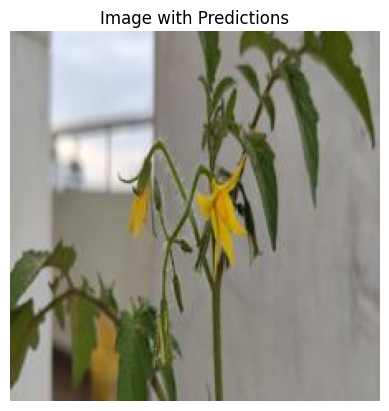

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\041.jpg")

Image loaded successfully!

0: 640x320 1 Tomato Unripe, 237.6ms
Speed: 3.0ms preprocess, 237.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step

Fruiting

Tomato Counts:
- 0 Tomato Ripe
- 0 Tomato Semi-ripe
- 1 Tomato Unripe
- 0 Unsure
Total Tomatoes: 1

Flowers detected


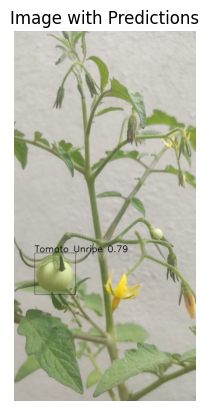

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\0121.jpg")

Image loaded successfully!

0: 288x640 2 Tomato Fully-ripes, 248.9ms
Speed: 0.0ms preprocess, 248.9ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

Fruiting

Tomato Counts:
- 2 Tomato Ripe
- 0 Tomato Semi-ripe
- 0 Tomato Unripe
- 0 Unsure
Total Tomatoes: 2


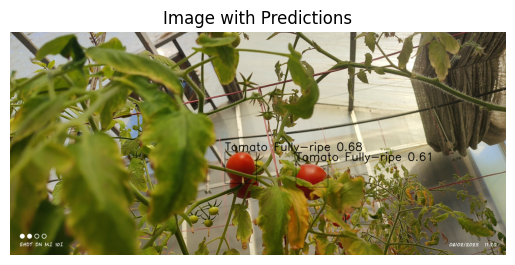

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\IMG_20250206_112037.jpg")

Image loaded successfully!

0: 640x288 3 Tomato Fully-ripes, 1 Tomato Unripe, 236.1ms
Speed: 15.6ms preprocess, 236.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

Fruiting

Tomato Counts:
- 3 Tomato Ripe
- 0 Tomato Semi-ripe
- 1 Tomato Unripe
- 0 Unsure
Total Tomatoes: 4


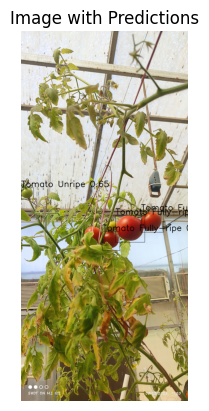

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\IMG_20250206_112044.jpg")

Image loaded successfully!

0: 640x288 1 Tomato Fully-ripe, 1 Tomato Unripe, 233.8ms
Speed: 0.0ms preprocess, 233.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

Fruiting

Tomato Counts:
- 1 Tomato Ripe
- 0 Tomato Semi-ripe
- 1 Tomato Unripe
- 0 Unsure
Total Tomatoes: 2


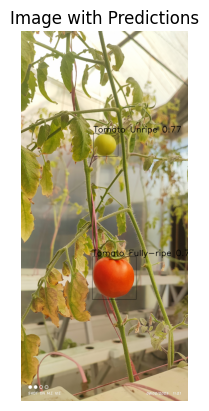

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\IMG_20250206_112107.jpg")

Image loaded successfully!

0: 640x288 3 Tomato Unripes, 197.7ms
Speed: 0.0ms preprocess, 197.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

Fruiting

Tomato Counts:
- 0 Tomato Ripe
- 0 Tomato Semi-ripe
- 2 Tomato Unripe
- 1 Unsure
Total Tomatoes: 3


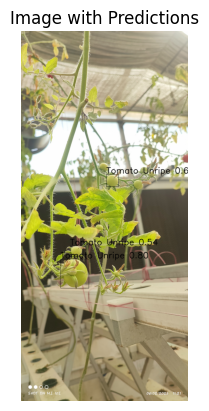

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\IMG_20250206_112142.jpg")

Image loaded successfully!

0: 640x288 (no detections), 198.8ms
Speed: 0.0ms preprocess, 198.8ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
No Tomatoes or Flowers detected

Tomato Counts:
Total Tomatoes: 0


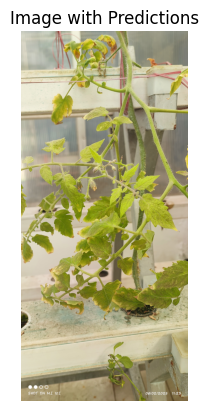

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\IMG_20250206_112305.jpg")


Image loaded successfully!

0: 640x288 3 Tomato Fully-ripes, 1 Tomato Semi-ripe, 1 Tomato Unripe, 167.3ms
Speed: 15.6ms preprocess, 167.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

Fruiting

Tomato Counts:
- 3 Tomato Ripe
- 1 Tomato Semi-ripe
- 1 Tomato Unripe
- 0 Unsure
Total Tomatoes: 5


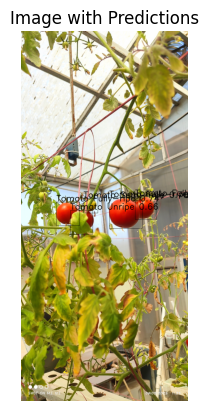

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\IMG_20250206_113229.jpg")

Image loaded successfully!

0: 640x288 1 Tomato Semi-ripe, 4 Tomato Unripes, 211.7ms
Speed: 0.0ms preprocess, 211.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

Fruiting

Tomato Counts:
- 0 Tomato Ripe
- 1 Tomato Semi-ripe
- 4 Tomato Unripe
- 0 Unsure
Total Tomatoes: 5


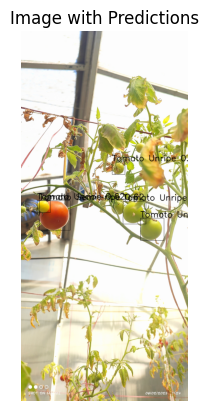

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\IMG_20250206_113254.jpg")

Image loaded successfully!

0: 640x288 1 Tomato Semi-ripe, 2 Tomato Unripes, 222.6ms
Speed: 15.7ms preprocess, 222.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

Fruiting

Tomato Counts:
- 0 Tomato Ripe
- 1 Tomato Semi-ripe
- 2 Tomato Unripe
- 0 Unsure
Total Tomatoes: 3


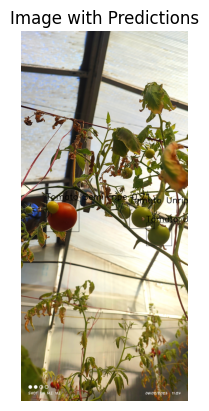

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\IMG_20250206_113315.jpg")

Image loaded successfully!

0: 640x288 (no detections), 228.4ms
Speed: 0.0ms preprocess, 228.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Flowering

Tomato Counts:
Total Tomatoes: 0

Flowers detected


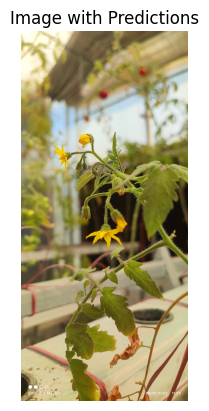

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\IMG_20250206_113334.jpg")

Image loaded successfully!

0: 640x288 (no detections), 249.5ms
Speed: 0.0ms preprocess, 249.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Flowering

Tomato Counts:
Total Tomatoes: 0

Flowers detected


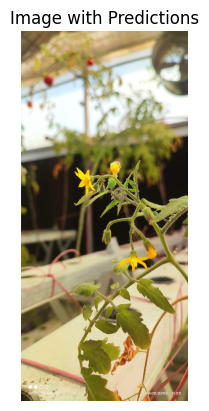

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\IMG_20250206_113352.jpg")

Image loaded successfully!

0: 640x288 2 Tomato Semi-ripes, 1 Tomato Unripe, 214.6ms
Speed: 3.5ms preprocess, 214.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step

Fruiting

Tomato Counts:
- 0 Tomato Ripe
- 1 Tomato Semi-ripe
- 1 Tomato Unripe
- 1 Unsure
Total Tomatoes: 3


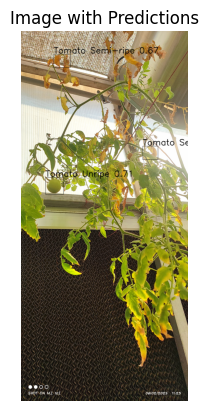

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\IMG_20250206_113416.jpg")

Image loaded successfully!

0: 640x288 2 Tomato Unripes, 274.0ms
Speed: 0.0ms preprocess, 274.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step

Fruiting

Tomato Counts:
- 0 Tomato Ripe
- 1 Tomato Semi-ripe
- 1 Tomato Unripe
- 0 Unsure
Total Tomatoes: 2


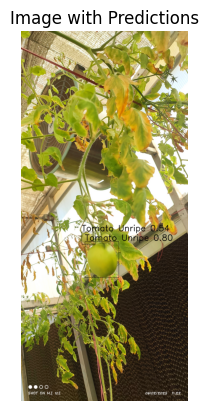

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\IMG_20250206_113435.jpg")

Image loaded successfully!

0: 640x288 1 Tomato Fully-ripe, 215.4ms
Speed: 0.0ms preprocess, 215.4ms inference, 16.9ms postprocess per image at shape (1, 3, 640, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step

Fruiting

Tomato Counts:
- 1 Tomato Ripe
- 0 Tomato Semi-ripe
- 0 Tomato Unripe
- 0 Unsure
Total Tomatoes: 1


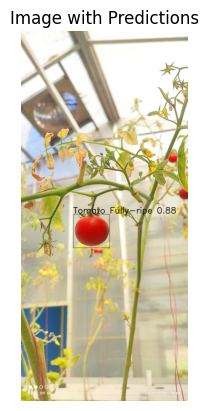

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\IMG_20250206_113523.jpg")

Image loaded successfully!

0: 640x288 (no detections), 231.8ms
Speed: 0.9ms preprocess, 231.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Flowering

Tomato Counts:
Total Tomatoes: 0

Flowers detected


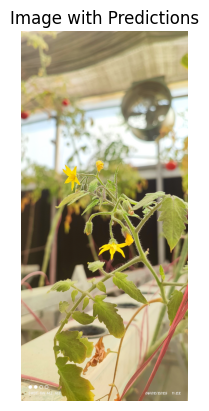

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\IMG_20250206_113559.jpg")

Image loaded successfully!

0: 640x288 1 Tomato Fully-ripe, 1 Tomato Unripe, 226.2ms
Speed: 2.7ms preprocess, 226.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

Fruiting

Tomato Counts:
- 0 Tomato Ripe
- 0 Tomato Semi-ripe
- 2 Tomato Unripe
- 0 Unsure
Total Tomatoes: 2


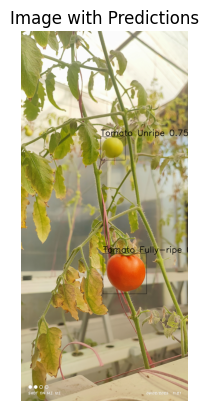

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\IMG_20250206_113631.jpg")

Image loaded successfully!

0: 640x288 1 Tomato Fully-ripe, 230.9ms
Speed: 3.0ms preprocess, 230.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

Fruiting

Tomato Counts:
- 1 Tomato Ripe
- 0 Tomato Semi-ripe
- 0 Tomato Unripe
- 0 Unsure
Total Tomatoes: 1


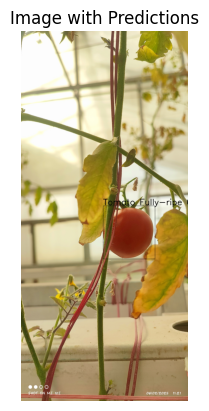

In [ ]:
process_and_display(r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test\IMG_20250206_113654.jpg")

Or just run 

<code>
    import os

    images = r"D:\Tomato Plant Growth Monitoring Project\Dataset\Test"

    for img in os.listdir(images):
    
        img_path = os.path.join(images, img)  
    
        process_and_display(img_path)
</code>